In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
import os

In [3]:
from utils.pipeline import run_matches_discovery, discovery_pipeline
from utils.pipeline_wrappers import gen_expname, run_until_coverage_th, try_run_exp, cv_experiment, monitor_callback, grid_exp
from utils.feature_utils import op_100, get_feats, get_seq_names, get_dh_feats_wrap, load_feats
from utils.helper_fncs import load_json
from utils.skopt_tune import TunerSkopt

In [4]:
def set_optim_params(params, xopt):
    for i, key in enumerate(params['tune']['keys']):
        val = xopt[i]
        if isinstance(val, float): val = round(val,4)
        params['disc'][key] = val

def run_for_set(cvset, feat_loader, params):
    # get scores for set_x (params_optim)
    signers = ['Signer0{}'.format(x) for x in signers_per_set[cvset]]
    
    scores_dict = dict()
#    for params['CVset'] in [cvset] + signers:
    for params['CVset'] in [cvset] :
        seq_names = get_seq_names(params)
        
        feats_dict = feat_loader(seq_names, params['featype'], params)
        
        tmp_feats = {key: feats_dict[key] for key in seq_names}
        scores_dict[params['CVset']] = try_run_exp(tmp_feats, params, genname=True)


    return scores_dict

In [5]:
cvsets = set(['A','B','C'])
signers_per_set = {'A': [4,8,9], 'B':[2,5,7], 'C':[1,3,6]}

alg_type = 'zr_cat'
params = load_json(full_path='/home/korhan/Dropbox/config/{}.json'.format(alg_type))
params

{'CVroot': '/home/korhan/Dropbox/CVfolds',
 'clustering': {'cost_thr': 0.001, 'method': 'pairwise', 'olapthr_m': 0.25},
 'config_file': '/home/korhan/Dropbox/config/config_phoenix.json',
 'covth': 10,
 'dataset': 'phoenix',
 'disc': {'B': 300,
  'D': 15,
  'P': 4,
  'R': 15,
  'T': 0.5,
  'Tscore': 0.5,
  'castthr': 10,
  'dx': 6,
  'dy': 5,
  'medthr': 0.35,
  'rhothr': 0.0,
  'trimthr': 1.0,
  'n_concat': 20},
 'disc_method': 'zr_cat',
 'exp_root': '/home/korhan/Desktop/tez/zr_exps/',
 'feats_root': '/home/korhan/Desktop/tez/dataset/features/',
 'lr': 0.8,
 'lshroot': '/home/korhan/Desktop/tez/dataset/features/lsh',
 'maxth': 0.7,
 'mult': 1.1,
 'njobs': 2,
 'norm': 'gauss',
 'patience': 30,
 'zrroot': '/home/korhan/Desktop/zerospeech2017/track2/src/ZRTools/',
 'tune': {'keys': ['r', 's'],
  'minimizer': 'gp',
  'n_split': 1,
  'stop_margin': 0.01,
  'stopper_patience': 5}}

In [6]:
# change desired params here
# params['tune']['keys'] = ['r', 's']
params['tune']['keys'] = ['dx','castthr']
params['tune']['n_split'] = 1
params['disc']['n_concat'] = 20
params['disc']['R'] = 15
params['disc']['dx'] = 13
params['disc']['T'] = 0.35
params['disc']['medthr'] = 0.45
params['tune']['stopper_patience'] = 3
params['tune']['stop_margin'] = 1

params['featype'] = 'op100'
#params['featype'] = 'c3_right_PCA40'

# no pca -> 52% @22th iter 
# pca -> 40% 

params_default = params.copy()


In [21]:
params

{'CVroot': '/home/korhan/Dropbox/CVfolds',
 'clustering': {'cost_thr': 0.001, 'method': 'pairwise', 'olapthr_m': 0.25},
 'config_file': '/home/korhan/Dropbox/config/config_phoenix.json',
 'covth': 10,
 'dataset': 'phoenix',
 'disc': {'B': 300,
  'D': 15,
  'P': 4,
  'R': 15,
  'T': 0.35,
  'Tscore': 0.5,
  'castthr': 10,
  'dx': 13,
  'dy': 5,
  'medthr': 0.45,
  'rhothr': 0.0,
  'trimthr': 1.0,
  'n_concat': 20},
 'disc_method': 'zr_cat',
 'exp_root': '/home/korhan/Desktop/tez/zr_exps/',
 'feats_root': '/home/korhan/Desktop/tez/dataset/features/',
 'lr': 0.8,
 'lshroot': '/home/korhan/Desktop/tez/dataset/features/lsh',
 'maxth': 0.7,
 'mult': 1.1,
 'njobs': 2,
 'norm': 'gauss',
 'patience': 30,
 'zrroot': '/home/korhan/Desktop/zerospeech2017/track2/src/ZRTools/',
 'tune': {'keys': ['dx', 'castthr'],
  'minimizer': 'gp',
  'n_split': 1,
  'stop_margin': 1,
  'stopper_patience': 3},
 'featype': 'op100'}

In [ ]:

all_stats = dict()
tuners = dict()

for devset in sorted(cvsets):    
    testsets = sorted(cvsets - set(devset))
    
    # load related features
    params['CVset'] = devset
    seq_names = get_seq_names(params)
    feats_dict = load_feats(seq_names, params['featype'], params)

    
    # paramtune on devset
    print('=== Running Paramtune on Devset {} ==='.format(devset))
    tuner = TunerSkopt(seq_names, feats_dict, params)
    tuner.prepare(load_checkpoint=True)
    xopt, score_min = tuner.run(n_calls=5, n_random_starts=2)
    tuners[devset] = tuner
    print('=== Paramtune completed with min score {} ==='.format(score_min))

    set_optim_params(params, xopt)
    
    # re-run to get full stats
    stats = [run_for_set(setx, load_feats, params) for setx in sorted(cvsets)]
    
    all_stats[devset] = stats

    # re-set params
    params = params_default.copy()
    
    
# average dev, test scores

   

=== Running Paramtune on Devset A ===
Iteration No: 1 started. Searching for the next optimal point.
Checkpoint /home/korhan/Dropbox/tez/checkpoints/zr_cat/gp_A_op100_dx_castthr.pkl with score 72.42 loaded !!!
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 0.0211
Function value obtained: 72.4200
Current minimum: 72.4200
 === Running for new space {'dx': 24, 'castthr': 5.584700216998297} ===
zr_cat_A_op100_B300_D15_P4_R15_T0.35_Tscore0.5_castthr5.584700216998297_dx24_dy5_medthr0.45_rhothr0.0_trimthr1.0_n_concat20
0.001
*** Matches already discovered !!! ***
*** found 200000 matches ***
*** post disc completed, found 318 segments from 159 clusters ***
*** Coverage: 3.5900, NED: 80.03
trial 0 th:0.00100 cov:3.59000 err:-6.41000
0.0026462395543175488
*** Matches already discovered !!! ***
*** found 200000 matches ***
*** post disc completed, found 760 segments from 380 clusters ***
*** Coverage: 6.0900, NED: 80.42
trial 1 th:0.00265 cov:6.09000 err:-3.91000


Read 8648161 matches
Read 9094399 matches
Read 8643006 matches
Read 8722633 matches
Read 8669295 matches
*** found 200000 matches ***
*** pairwise clustering ***
*** post disc completed, found 272 segments from 136 clusters ***
*** Coverage: 4.2600, NED: 62.89
trial 0 th:0.00100 cov:4.26000 err:-5.74000
0.0022300469483568074
*** Matches already discovered !!! ***
*** found 200000 matches ***
*** pairwise clustering ***
*** post disc completed, found 564 segments from 282 clusters ***
*** Coverage: 7.2700, NED: 65.96
trial 1 th:0.00223 cov:7.27000 err:-2.73000
0.003228387378534775
*** Matches already discovered !!! ***
*** found 200000 matches ***
*** pairwise clustering ***
*** post disc completed, found 772 segments from 386 clusters ***
*** Coverage: 8.6100, NED: 67.41
trial 2 th:0.00323 cov:8.61000 err:-1.39000
0.00416228269885424
*** Matches already discovered !!! ***
*** found 200000 matches ***
*** pairwise clustering ***
*** post disc completed, found 984 segments from 492 clust

In [11]:
# res = tuners['A'].s
def top_n_results(res, n):
    return res.func_vals[np.argsort(res.func_vals)][:n], [res.x_iters[i] for i in np.argsort(res.func_vals)][:n]

In [12]:
top_n_results(tuners['A'].saved_res,15)

(array([72.42, 74.24, 81.81, 84.89, 90.23]),
 [[1, 10.069155048503804],
  [13, 10],
  [24, 5.584700216998297],
  [24, 17.945819722599964],
  [13, 30.0]])

In [13]:
top_n_results(tuners['B'].saved_res,15)

(array([77.41, 79.73]), [[24, 5.584700216998297], [13, 10]])

In [14]:
top_n_results(tuners['C'].saved_res,25)

AttributeError: 'TunerSkopt' object has no attribute 'saved_res'

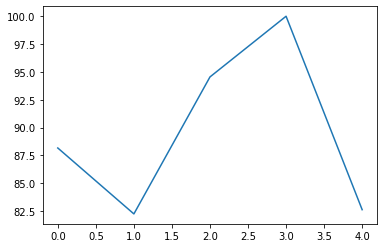

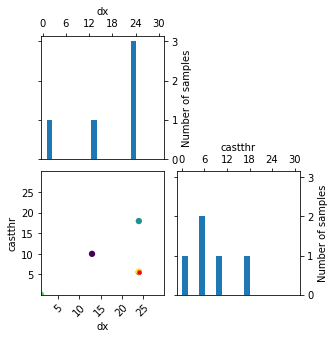

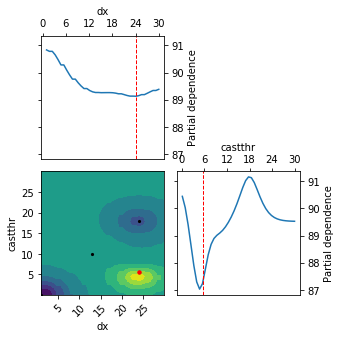

In [15]:
tuner._plot()

In [17]:
tuner.result

          fun: 41.58
    func_vals: array([ 42.15,  48.62,  65.65, 100.  ,  50.96,  84.12,  48.29,  79.93,
        48.58, 100.  ,  89.  ,  54.06, 100.  ,  44.2 ,  41.58,  48.99,
        49.61,  45.57,  47.13,  43.79,  44.77,  48.44,  46.07,  43.61,
        44.4 ])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=1608637542), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=16086375

In [16]:
dflist = []
for devset, stats in all_stats.items():
    dflist.append(pd.DataFrame([{**{'devset':devset},**{'set':key}, **item} 
                                for sublist in stats for key,item in sublist.items()]))
    
df = pd.concat(dflist, ignore_index=True)
df #.to_csv('../results/cv/{}_{}.csv'.format(params['disc_method'], params['featype']))

,devset,set,ned,coverage,coverageNS,coverageNS_f,grouping_F,grouping_P,grouping_R,token_F,...,R,T,Tscore,castthr,dx,dy,medthr,rhothr,trimthr,n_concat
0,A,A,69.60,10.01,9.87,12.99,3.58,1.99,18.57,0.08,...,15,0.35,0.5,11.5142,1,5,0.45,0.0,1.0,20
1,A,B,71.08,9.43,9.16,10.97,1.02,0.56,6.35,0.15,...,15,0.35,0.5,11.5142,1,5,0.45,0.0,1.0,20
2,A,C,86.76,9.56,9.38,11.48,0.94,0.50,8.00,0.15,...,15,0.35,0.5,11.5142,1,5,0.45,0.0,1.0,20
3,B,A,81.84,9.85,9.91,13.63,3.72,2.05,21.18,0.02,...,15,0.35,0.5,5.7035,24,5,0.45,0.0,1.0,20
4,B,B,76.73,9.76,9.77,12.36,2.13,1.14,16.90,0.06,...,15,0.35,0.5,5.7035,24,5,0.45,0.0,1.0,20
5,B,C,82.79,9.54,9.43,11.93,2.59,1.42,15.74,0.09,...,15,0.35,0.5,5.7035,24,5,0.45,0.0,1.0,20
6,C,A,82.33,9.01,9.10,12.55,2.76,1.52,15.38,0.03,...,15,0.35,0.5,5.5847,24,5,0.45,0.0,1.0,20
7,C,B,77.63,9.85,9.84,12.61,2.00,1.09,13.19,0.07,...,15,0.35,0.5,5.5847,24,5,0.45,0.0,1.0,20
8,C,C,82.55,9.67,9.53,12.10,2.66,1.46,15.65,0.08,...,15,0.35,0.5,5.5847,24,5,0.45,0.0,1.0,20


In [17]:
df[['devset','set','ned']+ params['tune']['keys'] ].style.background_gradient(cmap='Blues')

,devset,set,ned,dx,castthr
0,A,A,69.600000,1,11.514200
1,A,B,71.080000,1,11.514200
2,A,C,86.760000,1,11.514200
3,B,A,81.840000,24,5.703500
4,B,B,76.730000,24,5.703500
5,B,C,82.790000,24,5.703500
6,C,A,82.330000,24,5.584700
7,C,B,77.630000,24,5.584700
8,C,C,82.550000,24,5.584700


In [18]:
dfname = '../results/cv/{}_{}_{}.csv'.format(params['disc_method'], params['featype'], '_'.join(params['tune']['keys']))
dfname

'../results/cv/zr_cat_op100_dx_castthr.csv'

In [19]:
df.to_csv(dfname)

In [17]:
nfolder_persigner = [1475,
                    49,
                    470,
                    836,
                    1296,
                    30,
                    646,
                    704,
                    165]

report_cols = ['ned','length_avg', 'n_clus', 'n_node',
              'grouping_P', 'grouping_R', 'grouping_F', 
              'nfile']

signers_per_set = {'A': [4,8,9], 'B':[2,5,7], 'C':[1,3,6]}

In [18]:
nfolder_perset = dict()
for devset in ['A','B','C']:
    nfolder_perset[devset] = 0
    for i in signers_per_set[devset]:
        key = 'Signer0{}'.format(i) 
        nfolder_perset[key] = nfolder_persigner[i-1]
        nfolder_perset[devset] += nfolder_persigner[i-1]
nfolder_perset

{'A': 1705,
 'Signer04': 836,
 'Signer08': 704,
 'Signer09': 165,
 'B': 1991,
 'Signer02': 49,
 'Signer05': 1296,
 'Signer07': 646,
 'C': 1975,
 'Signer01': 1475,
 'Signer03': 470,
 'Signer06': 30}

In [106]:
for setx in ['A']:
    signers = ['Signer0{}'.format(x) for x in signers_per_set[setx]]
    print(signers)

['Signer04', 'Signer08', 'Signer09']


In [74]:
for i, key in enumerate(params['tune']['keys']):
    print(i,key)

0 r
1 s


In [80]:
set_optim_params(params, xopt)

In [114]:
sorted(cvsets)

['A0', 'B', 'C']

In [ ]:
# for each fold collect these stats
# dev set: [signer_ids], n_seq: , param_opt: scores@min: test set: 


In [30]:
import glob
from utils.helper_fncs import load_obj2

In [31]:
expdir = glob.glob('../../Desktop/tez/zr_exps/zr_cat_A0_c3_right_PCA40_B300_D15_P4_R15_T0.5_Tscore0.5_castthr6.931579073802557_dx1_dy15_medthr0.6796555883781742_rhothr0.0_trimthr1.0_n_concat20/postpairwise_cost0.0019772827233045893_olap0.25/*')

In [32]:
clusters_tde = load_json(expdir[0])
len(clusters_tde)

278

In [33]:
clusters_tde

{'1': [['05January_2011_Wednesday_tagesschau_default-0',
   0.0,
   32.0,
   [[0.0, 5.0, '__ON__'], [5.0, 21.0, 'JETZT'], [21.0, 34.0, 'WETTER']],
   ['__ON__', 'JETZT', 'WETTER']],
  ['09June_2010_Wednesday_tagesschau_default-0',
   0.0,
   28.0,
   [[0.0, 7.0, '__ON__'], [7.0, 22.0, 'JETZT'], [22.0, 30.0, 'WETTER']],
   ['__ON__', 'JETZT', 'WETTER']]],
 '2': [['22November_2009_Sunday_tagesschau_default-0',
   22.0,
   70.0,
   [[26.0, 41.0, 'WIE-AUSSEHEN'],
    [41.0, 49.0, 'MORGEN'],
    [49.0, 69.0, 'MONTAG']],
   ['WIE-AUSSEHEN', 'MORGEN', 'MONTAG']],
  ['01July_2011_Friday_tagesschau_default-0',
   34.0,
   68.0,
   [[36.0, 51.0, 'WIE-AUSSEHEN'],
    [51.0, 58.0, 'MORGEN'],
    [58.0, 75.0, 'SAMSTAG']],
   ['WIE-AUSSEHEN', 'MORGEN', 'SAMSTAG']]],
 '3': [['18November_2011_Friday_tagesschau_default-0',
   28.0,
   57.0,
   [[29.0, 45.0, 'WIE-AUSSEHEN'], [45.0, 51.0, 'MORGEN']],
   ['WIE-AUSSEHEN', 'MORGEN']],
  ['21January_2011_Friday_tagesschau_default-0',
   31.0,
   62.0,
   [[3